<a href="https://colab.research.google.com/github/mithil2311/Time_Series_Stock_Price_Forecast_/blob/master/Time_Series_Stock_Price_Forecast_using_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [0]:
plt.rcParams["figure.figsize"] = (12, 6)

Download stock price data from NSE [website](https://www.nseindia.com/products/content/equities/equities/eq_security.htm). Here I download stock price data for TCS stock.


In [101]:
df = pd.read_csv("https://raw.githubusercontent.com/abulbasar/data/master/tcs-stock.csv")
df.head()



,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,TCS,EQ,31-May-2018,3514.10,1734.0,1759.05,1726.10,1748.85,1741.05,1742.44,5049371,8.798250e+09,207998,3447026,68.27
1,TCS,EQ,01-Jun-2018,1741.05,1754.0,1757.50,1716.30,1732.00,1732.45,1742.29,1603856,2.794386e+09,74272,924751,57.66
2,TCS,EQ,04-Jun-2018,1732.45,1745.0,1749.00,1712.60,1742.00,1744.25,1730.25,1681483,2.909394e+09,96686,928452,55.22
3,TCS,EQ,05-Jun-2018,1744.25,1744.0,1751.90,1711.15,1723.00,1721.60,1728.88,2449568,4.235001e+09,133067,1492228,60.92
4,TCS,EQ,06-Jun-2018,1721.60,1723.0,1734.90,1715.20,1725.00,1725.75,1725.85,2236512,3.859875e+09,73770,1573892,70.37


Check whether you have duplicate data on by date. It looks like 11/2/2019, 18/2/2019, 25/2/2019 etc. have duplicate data. Not sure why there are duplicates by date. It could be ammendment to the data.

In [58]:
df[df["Date"].duplicated(keep = False)]

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
173,TCS,BL,11-Feb-2019,2604.20,2061.40,2061.40,2061.40,2061.40,2061.40,2061.40,376308,7.757213e+08,1,0,0.00
174,TCS,EQ,11-Feb-2019,2061.40,2060.00,2096.00,2048.90,2065.60,2065.90,2077.11,1778730,3.694622e+09,83603,901516,50.68
179,TCS,BL,18-Feb-2019,2061.40,2029.70,2029.70,2029.70,2029.70,2029.70,2029.70,2474600,5.022696e+09,1,0,0.00
180,TCS,EQ,18-Feb-2019,2029.70,2037.60,2041.95,1962.65,1969.60,1970.30,1988.87,2942184,5.851634e+09,100585,1668905,56.72
185,TCS,BL,25-Feb-2019,2029.70,1925.65,1925.65,1925.65,1925.65,1925.65,1925.65,1057509,2.036392e+09,2,0,0.00
186,TCS,EQ,25-Feb-2019,1925.65,1932.50,1990.00,1930.50,1987.00,1985.15,1961.61,2934880,5.757095e+09,140541,1341508,45.71
203,TCS,BL,22-Mar-2019,1925.65,2015.05,2015.05,2015.05,2015.05,2015.05,2015.05,264913,5.338129e+08,1,264913,100.00
204,TCS,EQ,22-Mar-2019,2015.05,2015.00,2016.00,1983.30,2010.00,2005.65,1998.96,3148149,6.293032e+09,155770,1787595,56.78


Drop the duplicate from the dataset.

In [0]:
df = df[~df["Date"].duplicated()]

Convert the dataset into time series data by undating the index to time series index. 

In [60]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,,,,
2018-05-31,TCS,EQ,31-May-2018,3514.10,1734.0,1759.05,1726.10,1748.85,1741.05,1742.44,5049371,8.798250e+09,207998,3447026,68.27
2018-06-01,TCS,EQ,01-Jun-2018,1741.05,1754.0,1757.50,1716.30,1732.00,1732.45,1742.29,1603856,2.794386e+09,74272,924751,57.66
2018-06-04,TCS,EQ,04-Jun-2018,1732.45,1745.0,1749.00,1712.60,1742.00,1744.25,1730.25,1681483,2.909394e+09,96686,928452,55.22
2018-06-05,TCS,EQ,05-Jun-2018,1744.25,1744.0,1751.90,1711.15,1723.00,1721.60,1728.88,2449568,4.235001e+09,133067,1492228,60.92
2018-06-06,TCS,EQ,06-Jun-2018,1721.60,1723.0,1734.90,1715.20,1725.00,1725.75,1725.85,2236512,3.859875e+09,73770,1573892,70.37


In [61]:
df.index

DatetimeIndex(['2018-05-31', '2018-06-01', '2018-06-04', '2018-06-05',
               '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-11',
               '2018-06-12', '2018-06-13',
               ...
               '2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24', '2019-05-27', '2019-05-28',
               '2019-05-29', '2019-05-30'],
              dtype='datetime64[ns]', name='Date', length=246, freq=None)

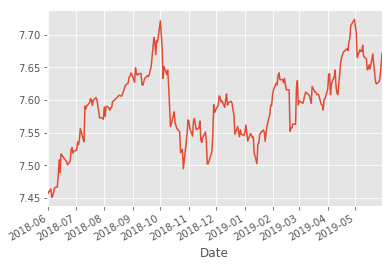

In [62]:
y = np.log(df["Close Price"])
y.plot()

In [64]:
y.index

DatetimeIndex(['2018-05-31', '2018-06-01', '2018-06-04', '2018-06-05',
               '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-11',
               '2018-06-12', '2018-06-13',
               ...
               '2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24', '2019-05-27', '2019-05-28',
               '2019-05-29', '2019-05-30'],
              dtype='datetime64[ns]', name='Date', length=246, freq=None)

Let's see if there are gaps in the data in terms of date range. Trading does not happen on weekends or national holidays. So there is no data on those days. 

In [65]:
list(y.index[:10])

[Timestamp('2018-05-31 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-06-04 00:00:00'),
 Timestamp('2018-06-05 00:00:00'),
 Timestamp('2018-06-06 00:00:00'),
 Timestamp('2018-06-07 00:00:00'),
 Timestamp('2018-06-08 00:00:00'),
 Timestamp('2018-06-11 00:00:00'),
 Timestamp('2018-06-12 00:00:00'),
 Timestamp('2018-06-13 00:00:00')]

In [66]:
y.asfreq("D")[:15]

Date
2018-05-31    7.462244
2018-06-01    7.457292
2018-06-02         NaN
2018-06-03         NaN
2018-06-04    7.464080
2018-06-05    7.451009
2018-06-06    7.453417
2018-06-07    7.459080
2018-06-08    7.465713
2018-06-09         NaN
2018-06-10         NaN
2018-06-11    7.467200
2018-06-12    7.484930
2018-06-13    7.508842
2018-06-14    7.488601
Freq: D, Name: Close Price, dtype: float64

Let's impute the missing data by forward fill using asfreq method.

In [67]:
y.asfreq("D", method="ffill")[:15]

Date
2018-05-31    7.462244
2018-06-01    7.457292
2018-06-02    7.457292
2018-06-03    7.457292
2018-06-04    7.464080
2018-06-05    7.451009
2018-06-06    7.453417
2018-06-07    7.459080
2018-06-08    7.465713
2018-06-09    7.465713
2018-06-10    7.465713
2018-06-11    7.467200
2018-06-12    7.484930
2018-06-13    7.508842
2018-06-14    7.488601
Freq: D, Name: Close Price, dtype: float64

For legitimate gaps, we can also set frequency to business days ("B")

In [68]:
y = y.asfreq("B")
y.index

DatetimeIndex(['2018-05-31', '2018-06-01', '2018-06-04', '2018-06-05',
               '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-11',
               '2018-06-12', '2018-06-13',
               ...
               '2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24', '2019-05-27', '2019-05-28',
               '2019-05-29', '2019-05-30'],
              dtype='datetime64[ns]', name='Date', length=261, freq='B')

Calculate quarterly high, low etc. 

In [69]:
pd.DataFrame(dict(low=y.resample("Q").min(), 
                  high=y.resample("Q").max(), 
                  first = y.resample("Q").first(), 
                  last = y.resample("Q").last(),
                  median = y.resample("Q").median(),
                  mean = y.resample("Q").mean()
                 ))

,low,high,first,last,median,mean
Date,,,,,,
2018-06-30,7.451009,7.527256,7.462244,7.521724,7.503576,7.491539
2018-09-30,7.523670,7.695508,7.523670,7.688776,7.602676,7.607829
2018-12-31,7.495042,7.721149,7.721149,7.545945,7.567837,7.572861
2019-03-31,7.502876,7.641516,7.551082,7.601727,7.593789,7.585512
2019-06-30,7.608126,7.723275,7.616604,7.671501,7.654088,7.655684


Calculate rolling mean, exponentially weighted mean

In [70]:
period = 3
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.head(10)

,actual,rolling_mean,ewm
Date,,,
2018-05-31,7.462244,NaN,7.462244
2018-06-01,7.457292,NaN,7.458942
2018-06-04,7.464080,7.461205,7.461878
2018-06-05,7.451009,7.457460,7.456081
2018-06-06,7.453417,7.456169,7.454706
2018-06-07,7.459080,7.454502,7.456928
2018-06-08,7.465713,7.459403,7.461355
2018-06-11,7.467200,7.463997,7.464289
2018-06-12,7.484930,7.472614,7.474630


In [71]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.011226801116974697
rmse over ewma:  0.008422829060485497


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test. 

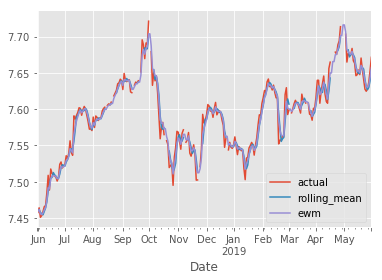

In [72]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary. 

In [73]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.645513
p-value: 0.083951


In [74]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2018-05-31,7.462244,NaN,NaN
2018-06-01,7.457292,NaN,NaN
2018-06-04,7.464080,NaN,NaN
2018-06-05,7.451009,-0.011234,NaN
2018-06-06,7.453417,-0.003875,0.007359
2018-06-07,7.459080,-0.005000,-0.001125
2018-06-08,7.465713,0.014703,0.019703
2018-06-11,7.467200,0.013783,-0.000921
2018-06-12,7.484930,0.025851,0.012068


In [75]:
result = adfuller(y.diff(periods=1).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.354529
p-value: 0.000000


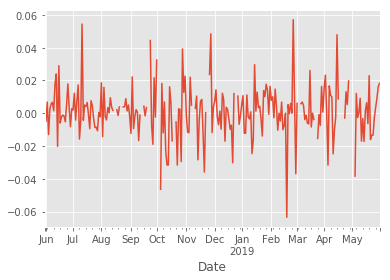

In [76]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the [autocorrelation plot](https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show) 

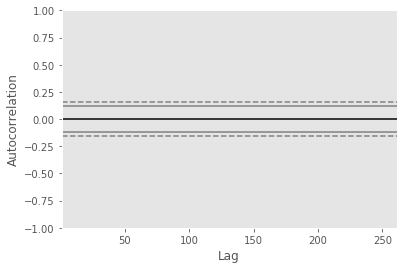

In [77]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [0]:
y = y.dropna()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                0
count  245.000000
mean    -0.000001
std      0.015648
min     -0.064712
25%     -0.007517
50%      0.000321
75%      0.007957
max      0.060259


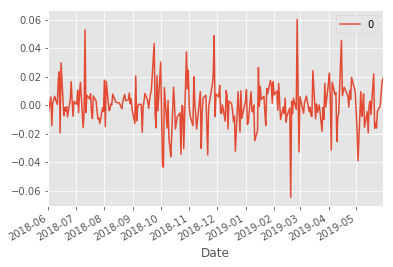

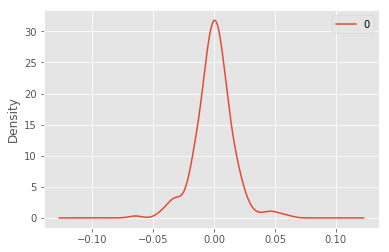

In [79]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(y, order=(5,1,0)) # p, d, q
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [80]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Close Price   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 671.412
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 27 Aug 2019   AIC                          -1328.824
Time:                        09:33:42   BIC                          -1304.315
Sample:                             1   HQIC                         -1318.954
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0008      0.001      0.922      0.357      -0.001       0.003
ar.L1.D.Close Price    -0.0124      0.064     -0.193      0.847      -0.138       0.113
ar.L2.D.Close Price    -0.0835      0.064     -1.307      0.193      -0.209       0.042
ar.L3.D.Close Price    -0.0153      0.064     -0.239      0.812      -0.141       0.110
ar.L4.D.Close Price    -0.0336      0.064     -0.526      0.599      -0.158       0.091
ar.L5.D.Close Price     0.0545      0.064      0.857      0.393      -0.070       0.179
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3265           -1.1035j            1.7255           -0.3896
AR.2           -1.3265           +1.1035j            1.7255            0.3896
AR.3            0.5898           -1.6129j            1.7173           -0.1942
AR.4            0.5898           +1.6129j            1.7173            0.1942
AR.5            2.0889           -0.0000j            2.0889           -0.0000
-----------------------------------------------------------------------------
"""

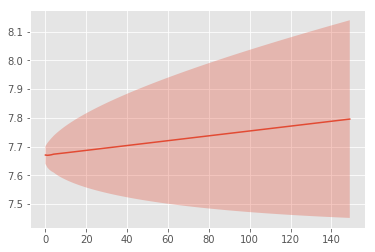

In [81]:
model = ARIMA(y.values, order=(5,1,0))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(150)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [82]:
predictions[:10]

array([7.67043094, 7.66948429, 7.67017584, 7.67145334, 7.67334406,
       7.67409747, 7.67475654, 7.67557197, 7.67642212, 7.67733182])

In [83]:
error[:10]

array([0.0156159 , 0.02194815, 0.02609877, 0.0295766 , 0.03251409,
       0.03556231, 0.03839146, 0.04097907, 0.0434079 , 0.04569467])

In [84]:
conf_interval[:10]

array([[7.63982434, 7.70103754],
       [7.62646671, 7.71250187],
       [7.61902319, 7.72132849],
       [7.61348427, 7.72942241],
       [7.60961761, 7.7370705 ],
       [7.60439662, 7.74379832],
       [7.59951065, 7.75000242],
       [7.59525447, 7.75588947],
       [7.5913442 , 7.76150003],
       [7.58777191, 7.76689172]])

In [85]:
model.endog

array([-0.00495179,  0.00678807, -0.01307057,  0.00240765,  0.00566263,
        0.0066329 ,  0.00148707,  0.01773066,  0.02391171, -0.02024075,
        0.02894678, -0.00602338, -0.00246339, -0.00112423, -0.00170246,
       -0.00526295,  0.00520799,  0.01784181,  0.0032345 , -0.00826875,
        0.0027368 ,  0.00194642,  0.01218676, -0.00422438,  0.00755385,
        0.01721521, -0.0157803 , -0.00420426,  0.05438435, -0.00432775,
        0.00493366,  0.0040803 ,  0.00648906, -0.00094943, -0.00946851,
        0.00764207,  0.00452246, -0.00332114, -0.00879292, -0.00851457,
       -0.01072046,  0.0004372 , -0.00226524,  0.01853654, -0.01431908,
        0.01581051, -0.00197219, -0.00415938,  0.00337448,  0.00017729,
        0.00945199,  0.00353096,  0.00169843,  0.00246757,  0.00211377,
       -0.0013921 ,  0.00382362,  0.00861149,  0.00387436,  0.00385941,
        0.00888334,  0.00135227,  0.00500675, -0.00192271, -0.01234494,
        0.02215997, -0.00940615, -0.00190153,  0.00219005,  0.00

In [86]:
(predictions + 1.96 * error)[:10]

array([7.7010381 , 7.71250267, 7.72132943, 7.72942348, 7.73707167,
       7.7437996 , 7.75000381, 7.75589094, 7.7615016 , 7.76689337])

In [87]:
(predictions - 1.96 * error)[:10]

array([7.63982378, 7.62646592, 7.61902225, 7.6134832 , 7.60961644,
       7.60439533, 7.59950926, 7.595253  , 7.59134264, 7.58777027])

predicted=7.642313, actual=7.631141
predicted=7.634232, actual=7.631141
predicted=7.632516, actual=7.626375
predicted=7.629072, actual=7.633079
predicted=7.634839, actual=7.622957
predicted=7.621720, actual=7.615643
predicted=7.617704, actual=7.615643
predicted=7.615724, actual=7.552132
predicted=7.554593, actual=7.557342
predicted=7.560087, actual=7.557055
predicted=7.551836, actual=7.563019
predicted=7.564309, actual=7.563019
predicted=7.552747, actual=7.620068
predicted=7.619829, actual=7.629539
predicted=7.627589, actual=7.592593
predicted=7.596197, actual=7.598600
predicted=7.602220, actual=7.594935
predicted=7.597300, actual=7.600702
predicted=7.603198, actual=7.607530
predicted=7.604694, actual=7.612189
predicted=7.613020, actual=7.608275
predicted=7.608681, actual=7.607108
predicted=7.608652, actual=7.601152
predicted=7.602319, actual=7.594583
predicted=7.596263, actual=7.620681
predicted=7.620880, actual=7.612238
predicted=7.610899, actual=7.612238
predicted=7.614528, actual=7

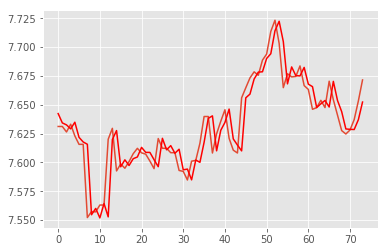

In [88]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

plt.plot(test)
plt.plot(predictions, color='red')


In [89]:
result = pd.DataFrame(y)[train_size:]
result.columns = ["actual"]
result["prediction"] = predictions
result

,actual,prediction
Date,,
2019-02-08,7.631141,7.642313
2019-02-11,7.631141,7.634232
2019-02-12,7.626375,7.632516
2019-02-13,7.633079,7.629072
2019-02-14,7.622957,7.634839
2019-02-15,7.615643,7.621720
2019-02-18,7.615643,7.617704
2019-02-19,7.552132,7.615724
2019-02-20,7.557342,7.554593


In [0]:
from numpy import array
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [91]:
y_b = np.log(df["Close Price"])
y_b = y_b.asfreq("B").dropna()/10.0
print("%s" % y_b[:10])

Date
2018-05-31    0.746224
2018-06-01    0.745729
2018-06-04    0.746408
2018-06-05    0.745101
2018-06-06    0.745342
2018-06-07    0.745908
2018-06-08    0.746571
2018-06-11    0.746720
2018-06-12    0.748493
2018-06-13    0.750884
Name: Close Price, dtype: float64


In [92]:
n_input = 5
train_size = int(0.7 * len(y_b))
y_b_train = y_b[:train_size]
y_b_test = y_b[train_size:]
generator_train = TimeseriesGenerator(y_b_train, y_b_train, length=n_input, batch_size=1, )
generator_test = TimeseriesGenerator(y_b_test, y_b_test, length=n_input, batch_size=1)
print('Samples: %d' % len(generator_train))
for i in range(3):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

Samples: 167
[[0.74622437 0.74572919 0.74640799 0.74510094 0.7453417 ]] => [0.74590796]
[[0.74572919 0.74640799 0.74510094 0.7453417  0.74590796]] => [0.74657125]
[[0.74640799 0.74510094 0.7453417  0.74590796 0.74657125]] => [0.74671996]


In [93]:
tf.set_random_seed(1)
np.random.seed(1)


model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (n_input,)),
    keras.layers.Dense(1, activation = None, kernel_initializer = keras.initializers.he_uniform(seed = 1.0))
])
model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 0.1))
model.summary()

model.fit_generator(generator_train, steps_per_epoch=1, epochs=500, verbose=0)
y_b_test_pred = model.predict_generator(generator_test, use_multiprocessing = True)
layer = model.layers[0]
print(layer.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
[array([[-0.3600253 ],
       [-0.4411793 ],
       [-0.32764933],
       [ 0.112325  ],
       [ 0.94929117]], dtype=float32), array([0.80706626], dtype=float32)]


In [94]:
y_b_test_pred.shape, y_b_test.shape

((69, 1), (74,))

In [95]:
metrics.mean_squared_error(y_b_test[n_input:] * 10.0, y_b_test_pred * 10.0) ** 0.5

0.08352339863386041